# End-to-end SR-native BO on a small grid

This notebook uses the SR-native BO implementation (s, r, delta) without learning in (x, y, phi).
We are verbose and test:

1) SR search grid creation + diagnostics
2) SR sampling diagnostics (random, random_mask, qmc)
3) Value-blocking heuristic in SR (multiple setups)
4) Heuristic-only search
5) BO run in SR space


In [18]:
import numpy as np
import matplotlib.pyplot as plt

from fire_model.ca import FireEnv, CAFireModel, FireState
from fire_model.bo_sr import RetardantDropBayesOptSR

np.set_printoptions(precision=3, suppress=True)
plt.rcParams["figure.dpi"] = 120

rng = np.random.default_rng(4)


In [19]:
# Helper: plot drop placements (x,y,phi) on the search mask.

def plot_drop_overlay(mask, params, title):
    plt.figure(figsize=(5.5, 5))
    plt.imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.25)
    if params.size:
        plt.quiver(
            params[:, 0],
            params[:, 1],
            np.sin(params[:, 2]),
            np.cos(params[:, 2]),
            angles="xy",
            scale_units="xy",
            scale=0.35,
            color="tab:blue",
            width=0.004,
        )
    plt.title(title)
    plt.tight_layout()
    plt.show()


def render_retardant(model, params, title):
    state = FireState(
        burning=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=bool),
        burned=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=bool),
        burn_remaining_s=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=float),
        retardant=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=float),
        t=0,
    )
    model.apply_retardant_cartesian(
        state,
        params,
        drop_w_km=model.env.drop_w_km,
        drop_h_km=model.env.drop_h_km,
        amount=1.0,
        avoid_burning=False,
        forbid_burning_overlap=False,
        burning_prob_threshold=0.25,
        cell_cap=None,
    )
    plt.figure(figsize=(5.5, 5))
    plt.imshow(state.retardant[0].T, origin="lower", aspect="equal", cmap="Reds")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_sr_points(bo, sr_params, title, step_s=16, step_r=8):
    if bo.sr_grid is None:
        raise RuntimeError("SR grid not initialized.")
    grid = bo.sr_grid
    mask = bo.search_domain_mask

    plt.figure(figsize=(5.5, 5))
    plt.imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.35)
    for j in range(0, grid.shape[1], max(1, grid.shape[1] // step_r)):
        curve = grid[:, j]
        plt.plot(curve[:, 0], curve[:, 1], color="tab:blue", linewidth=1)
    for i in range(0, grid.shape[0], max(1, grid.shape[0] // step_s)):
        curve = grid[i]
        plt.plot(curve[:, 0], curve[:, 1], color="tab:orange", linewidth=0.7, alpha=0.7)

    points = []
    dirs = []
    for s, r, delta in sr_params:
        xy, phi_base = bo._sr_lookup(float(s), float(r))
        phi_long = phi_base + float(delta) + 0.5 * np.pi
        points.append(xy)
        dirs.append(phi_long)

    if points:
        pts = np.asarray(points, dtype=float)
        dirs = np.asarray(dirs, dtype=float)
        plt.scatter(pts[:, 0], pts[:, 1], color="tab:blue", s=25)
        plt.quiver(
            pts[:, 0],
            pts[:, 1],
            np.sin(dirs),
            np.cos(dirs),
            angles="xy",
            scale_units="xy",
            scale=0.35,
            color="tab:purple",
            width=0.004,
        )

    if bo.init_boundary is not None:
        plt.plot(bo.init_boundary.xy[:, 0], bo.init_boundary.xy[:, 1], color="tab:red", linewidth=2)
    if bo.final_boundary is not None:
        plt.plot(bo.final_boundary.xy[:, 0], bo.final_boundary.xy[:, 1], color="tab:green", linewidth=2)

    plt.title(title)
    plt.tight_layout()
    plt.show()


In [20]:
# Environment: small grid, short time horizon.

nx = ny = 150
domain_km = 2.0

fuel = np.ones((nx, ny), dtype=float)
value = np.ones((nx, ny), dtype=float)

# Simple value peaks to show value blocking behavior.
X = np.arange(nx)[:, None]
Y = np.arange(ny)[None, :]
value += 30.0 * np.exp(-((X - 100) ** 2 + (Y - 20) ** 2) / (2 * 9.0 ** 2))
value += 10.0 * np.exp(-((X - 20) ** 2 + (Y - 120) ** 2) / (2 * 11.0 ** 2))
value_background = float(np.min(value))

# Constant wind.
wind = np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = 15.0
wind[..., 1] = -15.0

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    dt_s=4.0,
    burn_time_s0=500.0,
    retardant_half_life_s=3600.0,
    retardant_k=10.0,
    drop_w_km=0.05,
    drop_h_km=0.2,
    drop_amount=1.0,
    ros_mps=1.0,
    wind_coeff=0.08,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.25,
    ros_future_jitter_frac=0.05,
    wind_coeff_future_jitter_frac=0.05,
)

model = CAFireModel(env, seed=3)


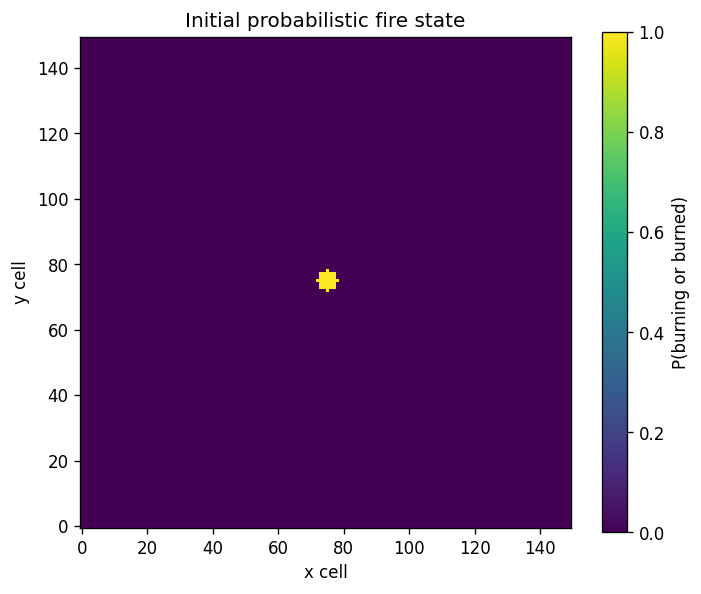

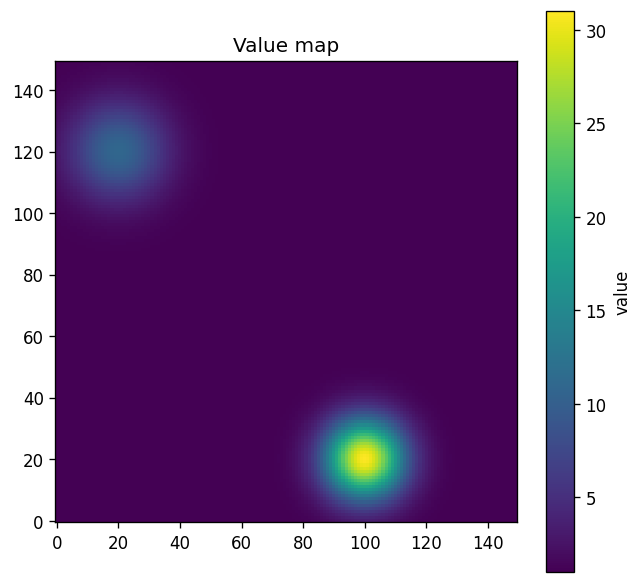

In [21]:
# Initial fire state (probabilistic via MC aggregation).

center = (nx // 2, ny // 2)
init_batch = model.init_state_batch(n_sims=60, center=center, radius_km=0.05)
init_state = model.aggregate_mc_to_state(init_batch)

model.plot_firestate(init_state, kind="p_affected", title="Initial probabilistic fire state")

plt.figure(figsize=(5.5, 5))
plt.imshow(value.T, origin="lower", aspect="equal", cmap="viridis")
plt.colorbar(label="value")
plt.title("Value map")
plt.tight_layout()
plt.show()


No drone_params
SR grid shape: (500, 150, 2)
Search mask coverage: 0.6242666666666666


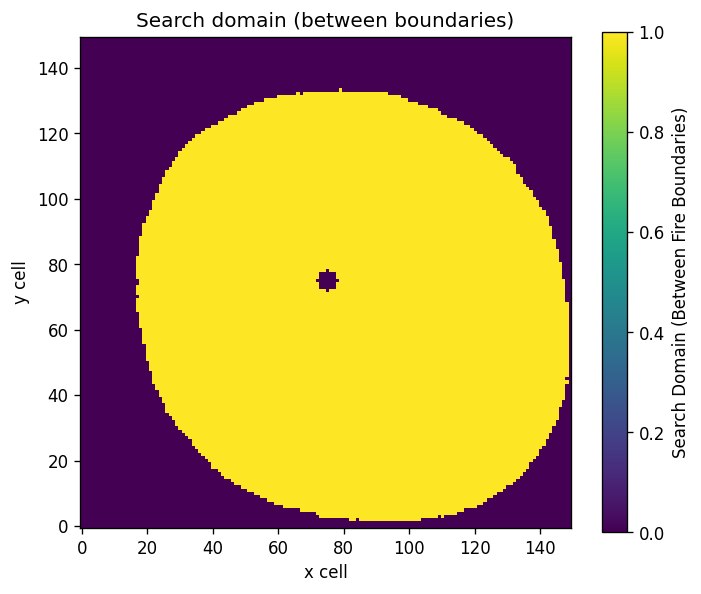

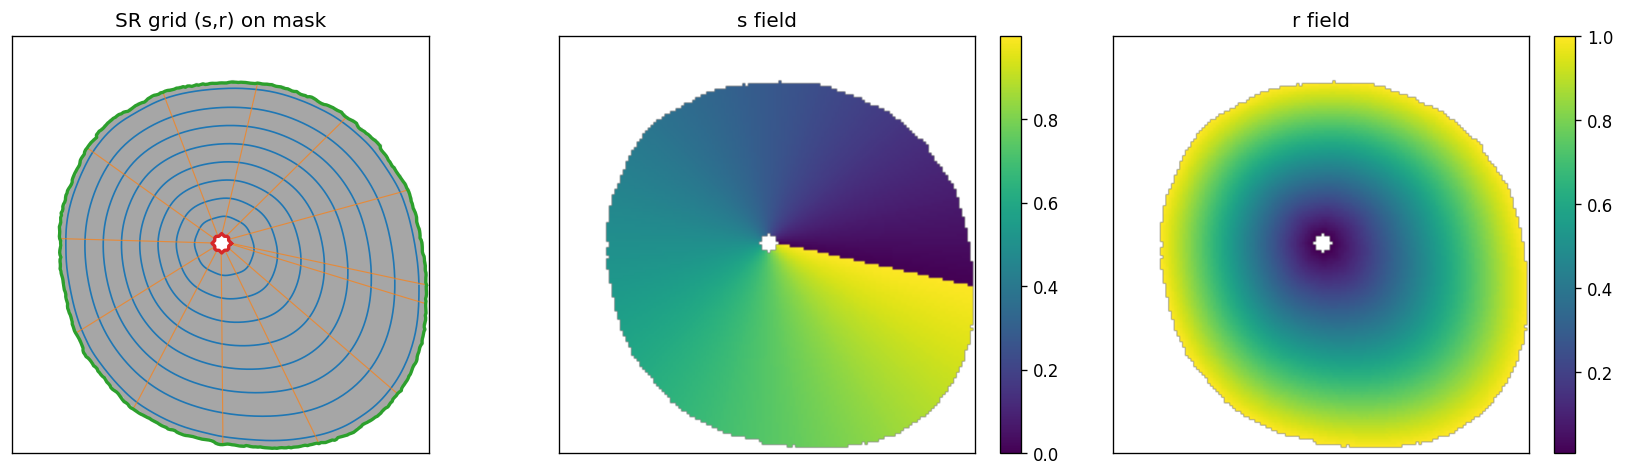

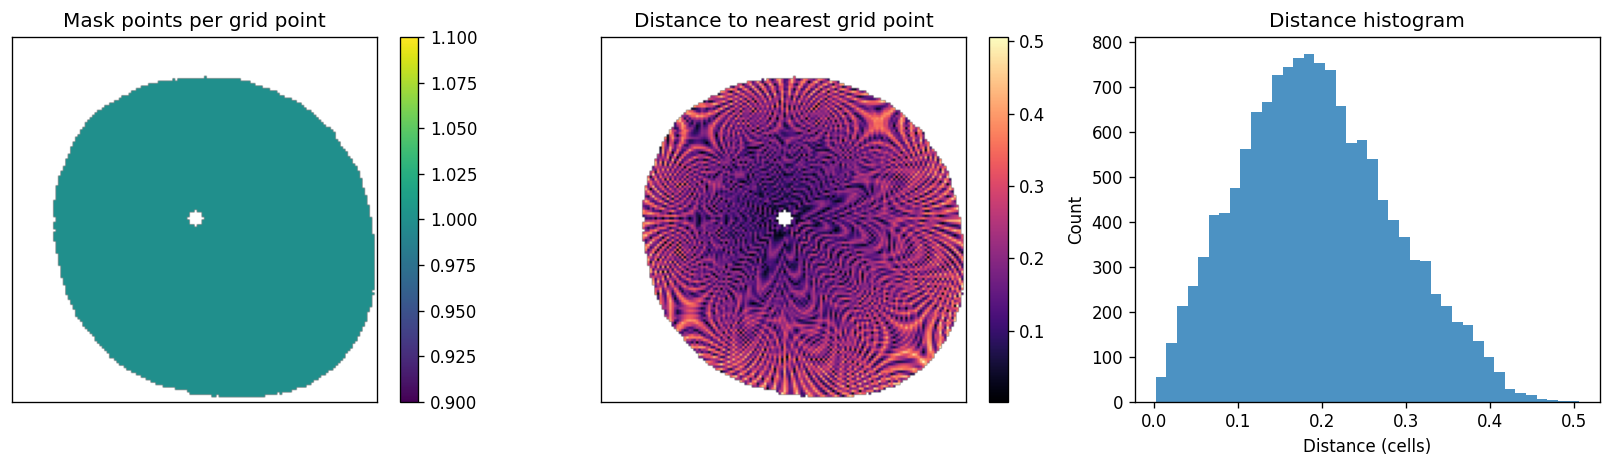

In [22]:
# Setup SR-native BO object and SR search grid.

bo = RetardantDropBayesOptSR(
    fire_model=model,
    init_firestate=init_state,
    n_drones=6,
    evolution_time_s=300.0,
    n_sims=60,
    fire_boundary_probability=0.5,
    search_grid_evolution_time_s=300.0,
)

bo.setup_search_grid_sr(
    K=500,
    boundary_field="affected",
    n_r=150,
    smooth_iters=300,
    omega=1.0,
)

print("SR grid shape:", bo.sr_grid.shape)
print("Search mask coverage:", float(np.mean(bo.search_domain_mask)))

model.plot_search_domain(bo.search_domain_mask, title="Search domain (between boundaries)")
bo.plot_sr_domain(show_fields=True, show_diagnostics=True)


In [23]:
# Check delta=0 orientation aligns with the local r-direction.

phi_r = bo.sr_phi_r_grid
valid = bo.sr_valid_mask
idx = np.column_stack(np.where(valid))

rng = np.random.default_rng(0)
sample_n = min(100, len(idx))
sample = idx[rng.choice(len(idx), size=sample_n, replace=False)]

angle_err = []
for i, j in sample:
    s = i / float(bo.sr_grid.shape[0])
    r = float(bo.sr_r_targets[j])
    theta = bo._encode_sr_params(np.array([[s, r, 0.0]]))
    phi = bo.decode_theta(theta)[0, 2]
    phi_long = 0.5 * np.pi - phi
    diff = np.arctan2(np.sin(phi_long - phi_r[i, j]), np.cos(phi_long - phi_r[i, j]))
    angle_err.append(abs(diff))

angle_err = np.asarray(angle_err)
print("delta=0 alignment (radians): mean", float(np.mean(angle_err)), "max", float(np.max(angle_err)))


delta=0 alignment (radians): mean 1.549980133305294 max 1.5707963267948968


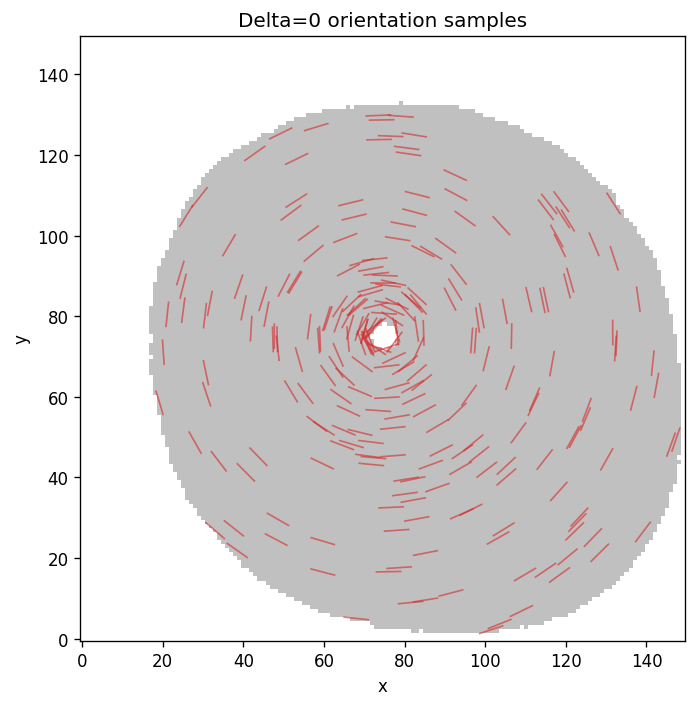

In [24]:
# Visualize delta=0 orientation samples across the SR grid.

phi_r = bo.sr_phi_r_grid
valid = bo.sr_valid_mask
idx = np.column_stack(np.where(valid))

rng = np.random.default_rng(1)
sample_n = min(250, len(idx))
sample = idx[rng.choice(len(idx), size=sample_n, replace=False)]

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(bo.search_domain_mask.T, origin="lower", cmap="gray_r", alpha=0.25)

seg_len = 0.04 * max(bo.search_domain_mask.shape)
for i, j in sample:
    s = i / float(bo.sr_grid.shape[0])
    r = float(bo.sr_r_targets[j])
    theta = bo._encode_sr_params(np.array([[s, r, 0.0]]))
    xy = bo.decode_theta(theta)[0, :2]
    phi = bo.decode_theta(theta)[0, 2]
    phi_long = 0.5 * np.pi - phi
    dx = 0.5 * seg_len * np.cos(phi_long)
    dy = 0.5 * seg_len * np.sin(phi_long)
    ax.plot([xy[0] - dx, xy[0] + dx], [xy[1] - dy, xy[1] + dy], color="tab:red", alpha=0.6, linewidth=1.0)

ax.set_title("Delta=0 orientation samples")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()


In [25]:
# Delta=0 chain diagnostics for one SR grid location.

K, R = bo.sr_grid.shape[:2]

# Choose a target (i,j); override if you want a specific location.
i = int(K * 0.55)
j = int(R * 0.4)
if not bo.sr_valid_mask[i, j]:
    _, idx = bo.sr_index_tree.query([i, j], k=1)
    i = int(bo.sr_valid_indices[idx, 0])
    j = int(bo.sr_valid_indices[idx, 1])

# SR parameters as used by the heuristics (note the denominator).
s = i / float(K)
r = float(bo.sr_r_targets[j])
xy_direct = bo.sr_grid[i, j]

# Decode lookup path (what decode_theta uses).
xy_lookup, phi_r_lookup = bo._sr_lookup(s, r)

# Indices chosen by decode_theta rounding.
i_round = int(np.round(np.clip(s, 0.0, 1.0) * (K - 1)))
j_round = int(np.round(np.clip(r, 0.0, 1.0) * (R - 1)))

phi_s = float(bo.sr_phi_s_grid[i, j])
phi_r = float(bo.sr_phi_r_grid[i, j])

# Delta=0 is aligned to the constant-r tangent via a +pi/2 shift from r-direction.
delta = 0.0
phi_long_from_delta = bo._wrap_angle(phi_r + delta + 0.5 * np.pi)
phi_model = bo._phi_from_long_axis_angle(phi_long_from_delta)
phi_long_from_model = bo._wrap_angle(0.5 * np.pi - phi_model)


def angle_diff(a, b):
    return np.arctan2(np.sin(a - b), np.cos(a - b))


def line_diff(a, b):
    d = abs(angle_diff(a, b))
    return min(d, np.pi - d)


print("chosen index (i,j):", (i, j))
print("s,r:", s, r)
print("rounded index used by decode:", (i_round, j_round))
print("xy direct:", xy_direct, "xy lookup:", xy_lookup, "dx:", float(np.linalg.norm(xy_direct - xy_lookup)))
print("phi_s (constant-r tangent):", phi_s)
print("phi_r (r direction):", phi_r)
print("phi_long_from_delta:", phi_long_from_delta)
print("phi_long_from_model (inverse mapping):", phi_long_from_model)
print("delta=0 vs phi_s (line diff):", float(line_diff(phi_long_from_delta, phi_s)))
print("delta=0 vs phi_r (line diff):", float(line_diff(phi_long_from_delta, phi_r)))
print("inverse mapping diff:", float(line_diff(phi_long_from_delta, phi_long_from_model)))


chosen index (i,j): (275, 60)
s,r: 0.55 0.40268456375838924
rounded index used by decode: (274, 60)
xy direct: [51.248 65.497] xy lookup: [51.152 65.846] dx: 0.3618472679629237
phi_s (constant-r tangent): -1.298299581836384
phi_r (r direction): -2.7486828086316257
phi_long_from_delta: 5.105298825342857
phi_long_from_model (inverse mapping): 5.105298825342857
delta=0 vs phi_s (line diff): 0.12041309999965374
delta=0 vs phi_r (line diff): 1.5707963267948963
inverse mapping diff: 0.0


Applying retardant drop: D=[[51.152 65.846  2.749]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
phi_pca (footprint long axis): 1.9583660261739329
pca vs phi_s (constant-r tangent): 0.11507295442052312
pca vs phi_r (r direction): 1.565456181215765
pca vs delta=0 long axis: 0.0053401455791299846


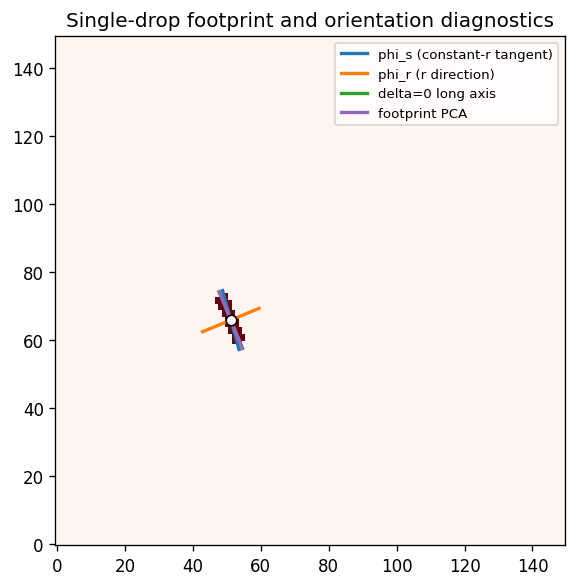

In [26]:
# Apply a single drop at this (s,r) with delta=0 and measure the actual footprint angle.

def pca_angle_from_mask(mask):
    coords = np.column_stack(np.where(mask))
    if coords.shape[0] < 5:
        return float("nan")
    coords = coords.astype(float)
    coords -= coords.mean(axis=0, keepdims=True)
    cov = coords.T @ coords / max(coords.shape[0] - 1, 1)
    eigvals, eigvecs = np.linalg.eigh(cov)
    v = eigvecs[:, np.argmax(eigvals)]
    return float(np.arctan2(v[1], v[0]))


state = FireState(
    burning=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=bool),
    burned=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=bool),
    burn_remaining_s=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=float),
    retardant=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=float),
    t=0,
)

params = np.array([[xy_lookup[0], xy_lookup[1], phi_model]], dtype=float)
model.apply_retardant_cartesian(
    state,
    params,
    drop_w_km=model.env.drop_w_km,
    drop_h_km=model.env.drop_h_km,
    amount=1.0,
    avoid_burning=False,
    forbid_burning_overlap=False,
    burning_prob_threshold=0.25,
    cell_cap=None,
)

mask = state.retardant[0] > 0
phi_pca = pca_angle_from_mask(mask)

print("phi_pca (footprint long axis):", phi_pca)
print("pca vs phi_s (constant-r tangent):", float(line_diff(phi_pca, phi_s)))
print("pca vs phi_r (r direction):", float(line_diff(phi_pca, phi_r)))
print("pca vs delta=0 long axis:", float(line_diff(phi_pca, phi_long_from_delta)))

# Visualize footprint and overlay expected directions.
plt.figure(figsize=(6, 5))
plt.imshow(state.retardant[0].T, origin="lower", aspect="equal", cmap="Reds")

seg = 0.12 * max(model.env.grid_size)
for ang, color, label in [
    (phi_s, "tab:blue", "phi_s (constant-r tangent)"),
    (phi_r, "tab:orange", "phi_r (r direction)"),
    (phi_long_from_delta, "tab:green", "delta=0 long axis"),
    (phi_pca, "tab:purple", "footprint PCA"),
]:
    if not np.isfinite(ang):
        continue
    dx = 0.5 * seg * np.cos(ang)
    dy = 0.5 * seg * np.sin(ang)
    plt.plot([xy_lookup[0] - dx, xy_lookup[0] + dx], [xy_lookup[1] - dy, xy_lookup[1] + dy], color=color, linewidth=2, label=label)

plt.scatter([xy_lookup[0]], [xy_lookup[1]], color="white", edgecolor="black", s=40, zorder=3)
plt.legend(loc="upper right", fontsize=8)
plt.title("Single-drop footprint and orientation diagnostics")
plt.tight_layout()
plt.show()


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo_sr.py:575: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


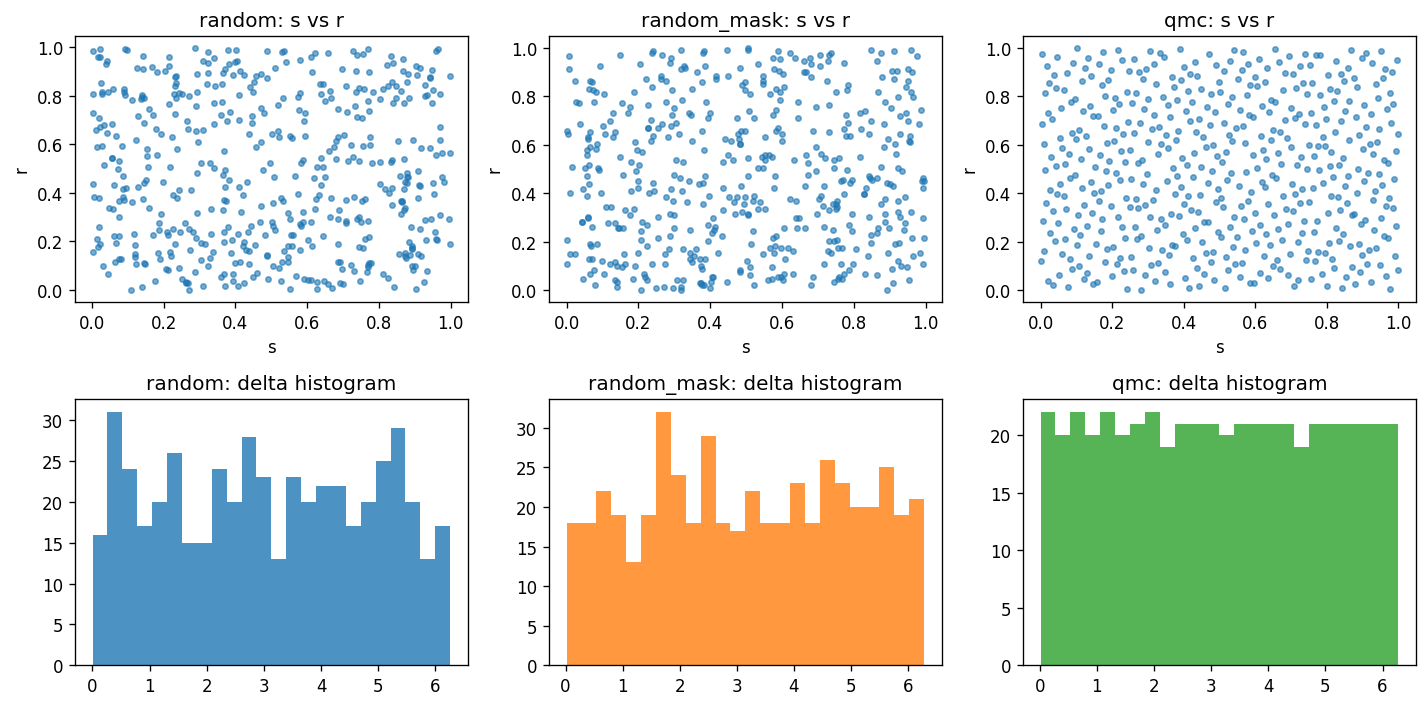

In [27]:
# SR sampling diagnostics (random, random_mask, qmc).

n_samples = 500

rand = bo.sample_random_theta(n_samples)
rand_mask = bo.sample_random_theta_on_mask(n_samples)
rand_qmc = bo.sample_qmc_theta(n_samples, method="sobol")

# For diagnostic plots we only inspect the first drone (index 0).

def extract_sr(theta):
    theta = np.atleast_2d(theta)
    s = theta[:, 0]
    r = theta[:, 1]
    delta = theta[:, 2] * (2.0 * np.pi)
    return s, r, delta

s_rand, r_rand, d_rand = extract_sr(rand)
s_mask, r_mask, d_mask = extract_sr(rand_mask)
s_qmc, r_qmc, d_qmc = extract_sr(rand_qmc)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

axes[0, 0].scatter(s_rand, r_rand, s=10, alpha=0.6)
axes[0, 0].set_title("random: s vs r")
axes[0, 0].set_xlabel("s")
axes[0, 0].set_ylabel("r")

axes[0, 1].scatter(s_mask, r_mask, s=10, alpha=0.6)
axes[0, 1].set_title("random_mask: s vs r")
axes[0, 1].set_xlabel("s")
axes[0, 1].set_ylabel("r")

axes[0, 2].scatter(s_qmc, r_qmc, s=10, alpha=0.6)
axes[0, 2].set_title("qmc: s vs r")
axes[0, 2].set_xlabel("s")
axes[0, 2].set_ylabel("r")

axes[1, 0].hist(d_rand, bins=24, color="tab:blue", alpha=0.8)
axes[1, 0].set_title("random: delta histogram")

axes[1, 1].hist(d_mask, bins=24, color="tab:orange", alpha=0.8)
axes[1, 1].set_title("random_mask: delta histogram")

axes[1, 2].hist(d_qmc, bins=24, color="tab:green", alpha=0.8)
axes[1, 2].set_title("qmc: delta histogram")

plt.tight_layout()
plt.show()



Config: weighted_peaks
  sr_params: [[0.782 0.658 0.   ]
 [0.796 0.805 0.   ]
 [0.802 0.893 0.   ]
 [0.818 0.779 0.   ]
 [0.83  0.671 0.   ]
 [0.842 0.691 0.   ]]
  xy_params: [[ 87.098  25.915   1.324]
 [ 94.488  15.778   1.249]
 [ 98.774   9.828   1.22 ]
 [100.848  26.898   1.077]
 [100.997  18.662   1.137]
 [104.86   26.668   1.018]]


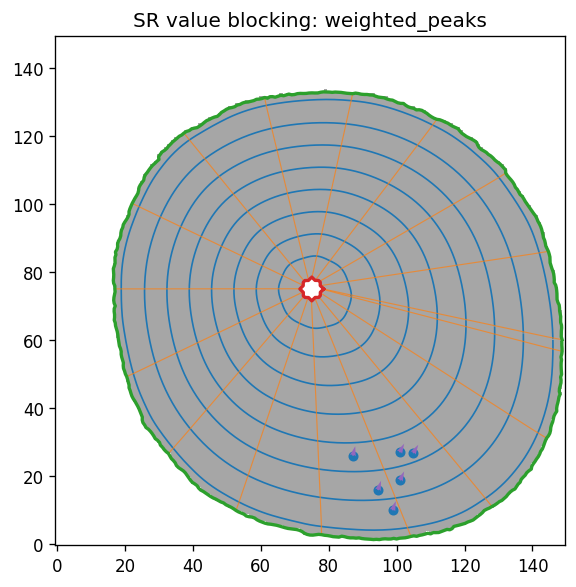

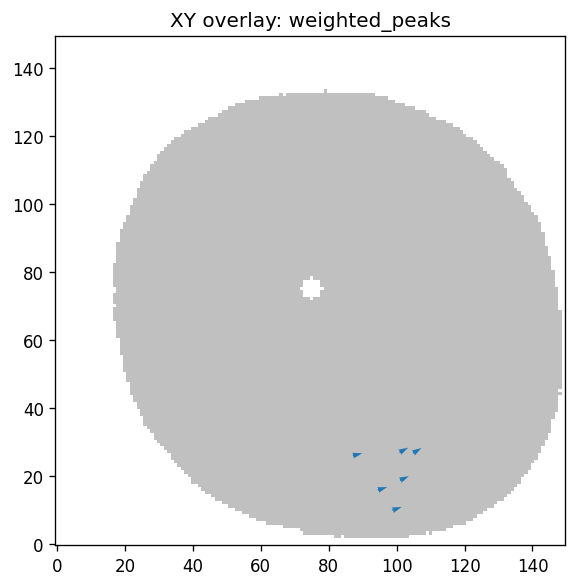

Applying retardant drop: D=[[ 87.098  25.915   1.324]
 [ 94.488  15.778   1.249]
 [ 98.774   9.828   1.22 ]
 [100.848  26.898   1.077]
 [100.997  18.662   1.137]
 [104.86   26.668   1.018]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


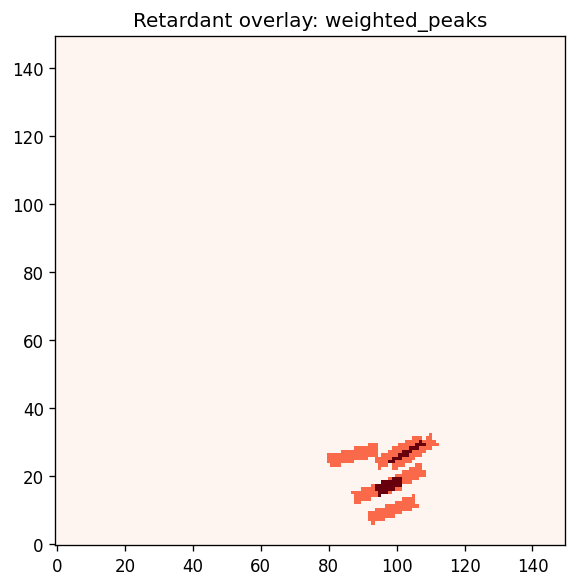

Applying retardant drop: D=[[ 87.098  25.915   1.324]
 [ 94.488  15.778   1.249]
 [ 98.774   9.828   1.22 ]
 [100.848  26.898   1.077]
 [100.997  18.662   1.137]
 [104.86   26.668   1.018]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


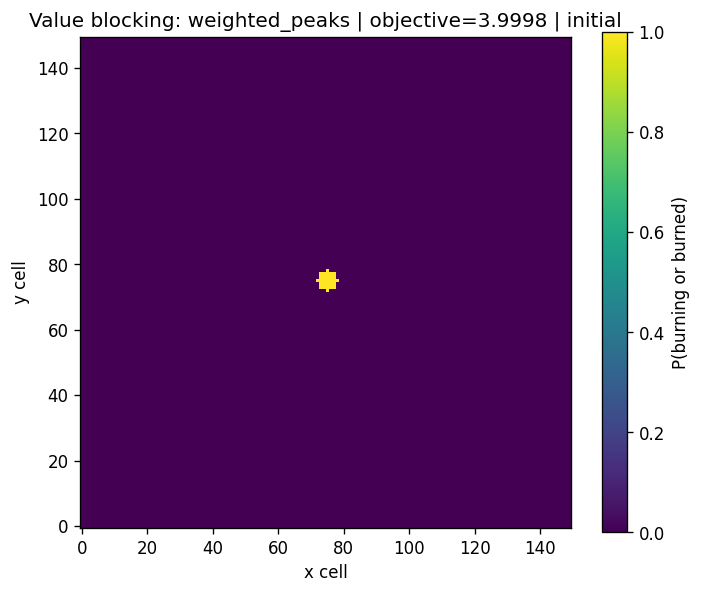

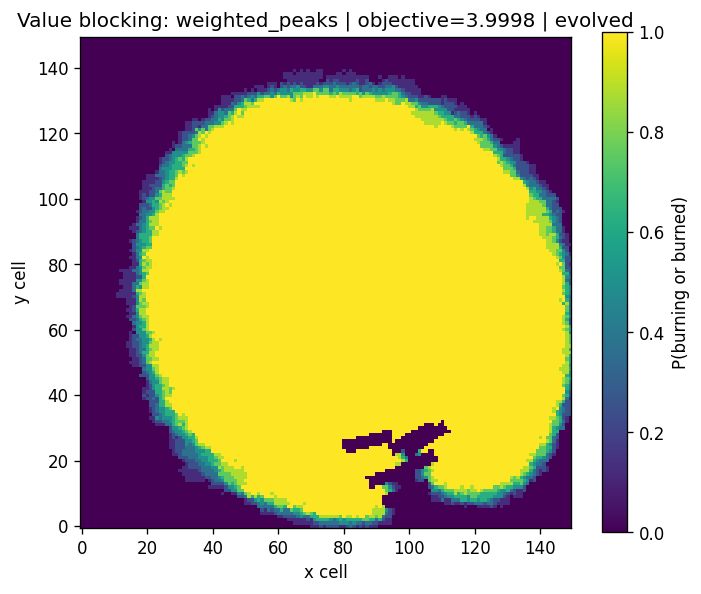

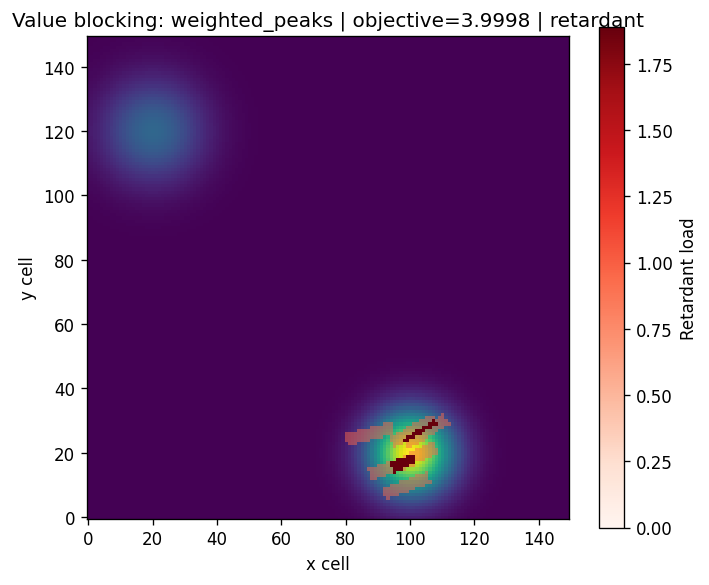


Config: inward_jittered
  sr_params: [[0.77  0.712 0.09 ]
 [0.814 0.786 0.035]
 [0.817 0.578 6.225]
 [0.826 0.819 6.244]
 [0.838 0.705 6.115]
 [0.869 0.618 6.248]]
  xy_params: [[ 84.388  22.2     1.299]
 [ 94.558  32.553   1.195]
 [ 99.922  17.948   1.122]
 [104.31   25.357   1.205]
 [104.937  16.504   1.137]
 [108.228  35.054   0.915]]


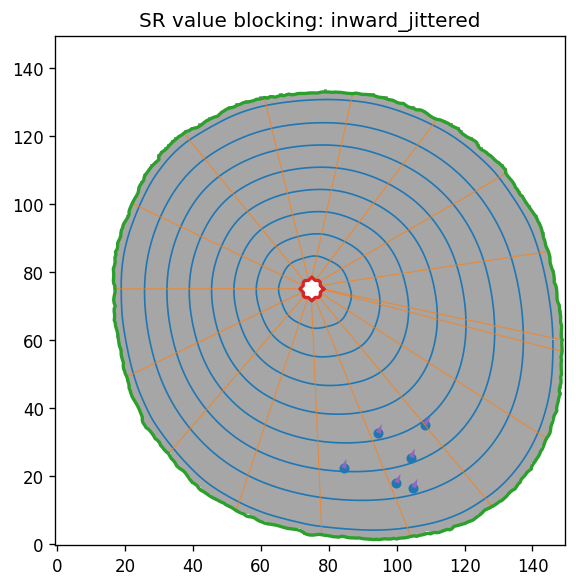

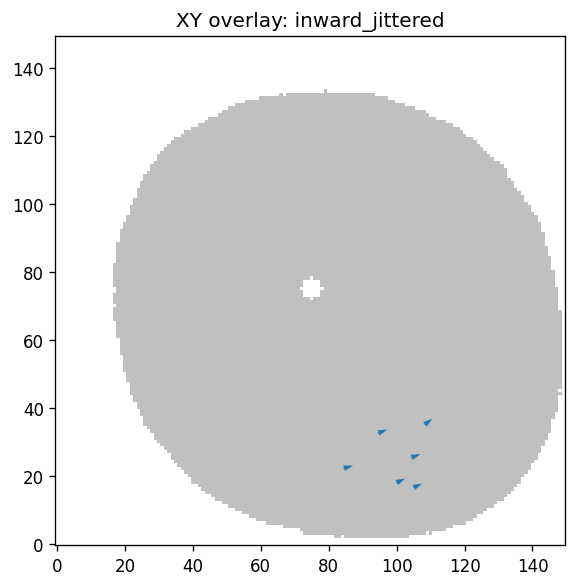

Applying retardant drop: D=[[ 84.388  22.2     1.299]
 [ 94.558  32.553   1.195]
 [ 99.922  17.948   1.122]
 [104.31   25.357   1.205]
 [104.937  16.504   1.137]
 [108.228  35.054   0.915]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


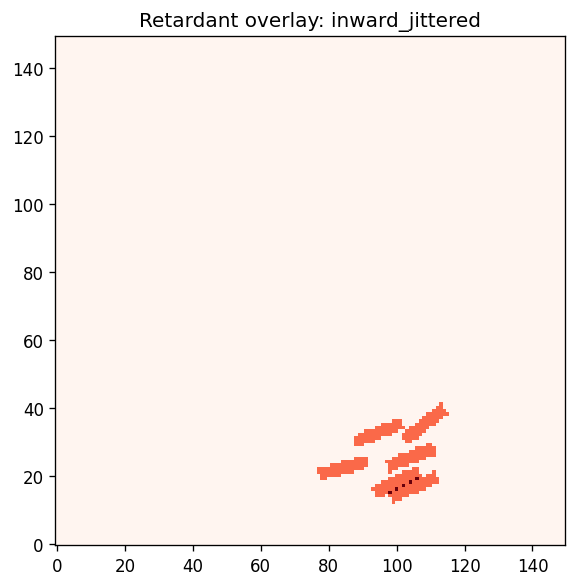

Applying retardant drop: D=[[ 84.388  22.2     1.299]
 [ 94.558  32.553   1.195]
 [ 99.922  17.948   1.122]
 [104.31   25.357   1.205]
 [104.937  16.504   1.137]
 [108.228  35.054   0.915]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


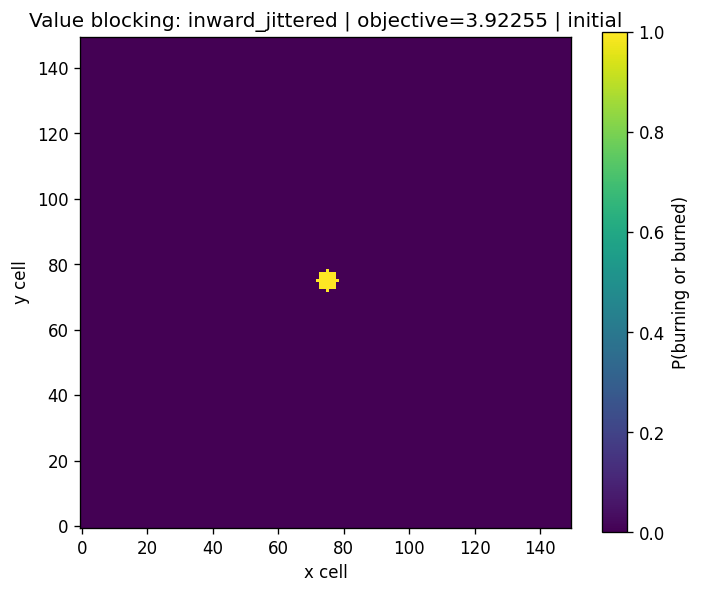

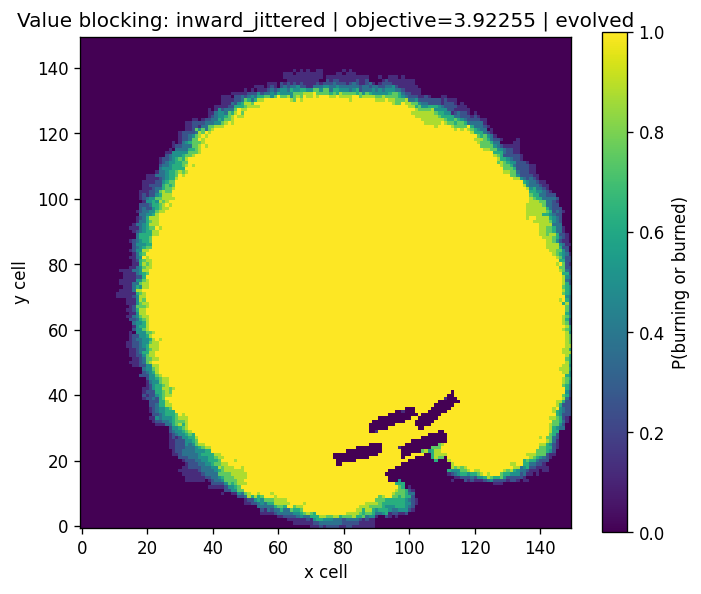

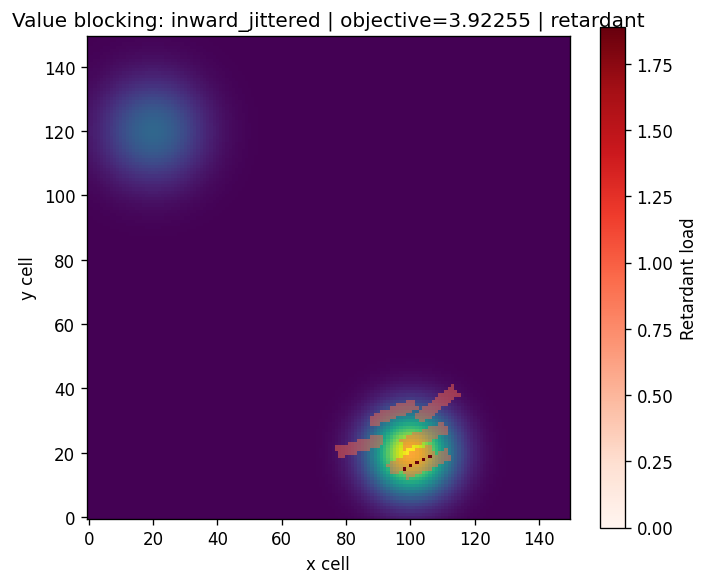

In [28]:
# Value-blocking heuristic tests (multiple setups).

configs = [
    #{"name": "greedy_top", "selection": "greedy", "value_power": 1.0, "value_offset": value_background, "r_offset": 0.0, "jitter_s": 0.0, "jitter_delta_rad": 0.0},
    #{"name": "weighted_linear", "selection": "weighted", "value_power": 1.0, "value_offset": value_background, "r_offset": 0.0, "jitter_s": 0.0, "jitter_delta_rad": 0.0},
    {"name": "weighted_peaks", "selection": "weighted", "value_power": 2.0, "value_offset": value_background, "r_offset": 0.0, "jitter_s": 0.0, "jitter_delta_rad": 0.0},
    {"name": "inward_jittered", "selection": "weighted", "value_power": 1.0, "value_offset": value_background, "r_offset": -0.08, "jitter_s": 0.05, "jitter_delta_rad": float(np.deg2rad(6.0))},
]

plot_n_sims = 8

for cfg in configs:
    placements = bo._sr_value_blocking(
        count=bo.n_drones,
        value_power=cfg["value_power"],
        value_offset=cfg.get("value_offset"),
        selection=cfg["selection"],
        r_offset=cfg["r_offset"],
        jitter_s=cfg["jitter_s"],
        jitter_delta_rad=cfg["jitter_delta_rad"],
    )

    theta = bo._encode_sr_params(np.asarray(placements, dtype=float))
    sr_params = bo.decode_theta_sr(theta)
    xy_params = bo.decode_theta(theta)

    print("\n" + f"Config: {cfg['name']}")
    print("  sr_params:", sr_params)
    print("  xy_params:", xy_params)

    plot_sr_points(bo, sr_params, f"SR value blocking: {cfg['name']}")
    plot_drop_overlay(bo.search_domain_mask, xy_params, f"XY overlay: {cfg['name']}")
    render_retardant(model, xy_params, f"Retardant overlay: {cfg['name']}")

    _ = bo.plot_evolved_firestate(theta, n_sims=plot_n_sims, title_prefix=f"Value blocking: {cfg['name']}")


ring SR params (s,r,delta): [[0.    0.6   0.   ]
 [0.167 0.6   0.   ]
 [0.333 0.6   0.   ]
 [0.5   0.6   0.   ]
 [0.667 0.6   0.   ]
 [0.833 0.6   0.   ]]
ring XY params (x,y,phi): [[ 39.282  74.003   3.111]
 [ 57.828  37.468   1.993]
 [ 61.036 107.569   4.317]
 [ 99.116  32.211   1.057]
 [101.734 103.08    5.492]
 [119.929  66.084   0.21 ]]


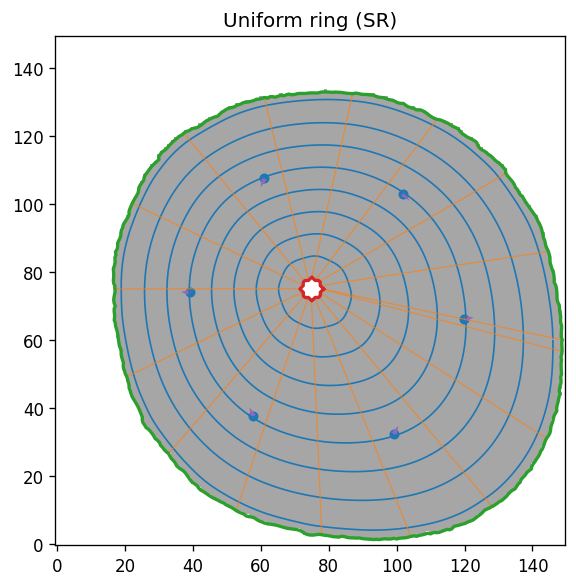

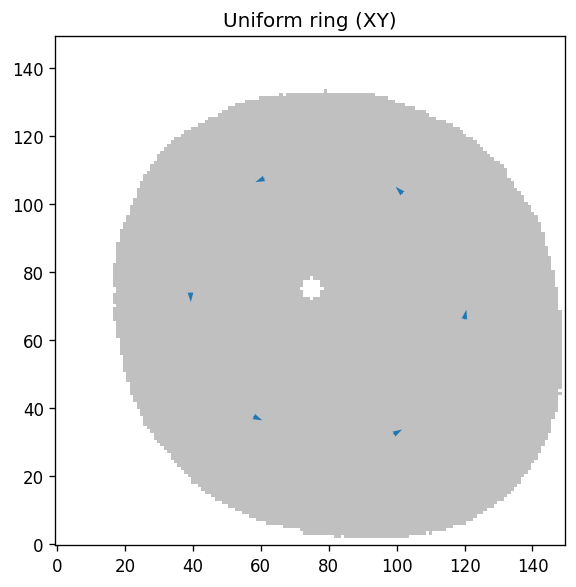

Applying retardant drop: D=[[ 39.282  74.003   3.111]
 [ 57.828  37.468   1.993]
 [ 61.036 107.569   4.317]
 [ 99.116  32.211   1.057]
 [101.734 103.08    5.492]
 [119.929  66.084   0.21 ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


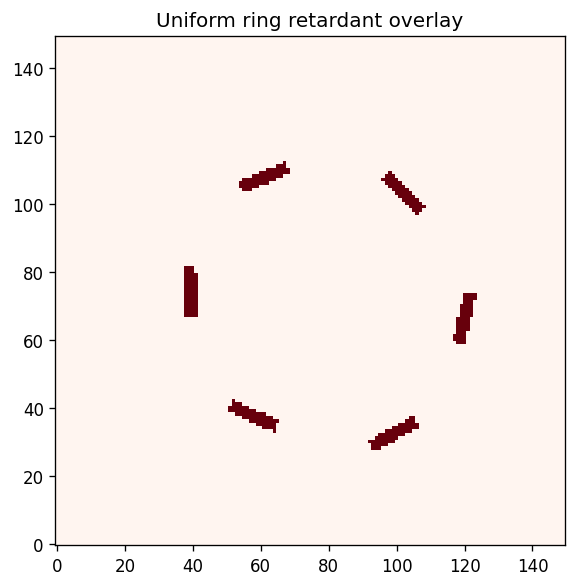

In [29]:
# Uniform ring heuristic: evenly spaced s at fixed r with delta=0.

ring_theta = bo.sample_uniform_ring_theta(
    n=1,
    r_min=0.6,
    r_max=0.6,
    phase=0.0,
)

ring_params_sr = bo.decode_theta_sr(ring_theta)
ring_params_xy = bo.decode_theta(ring_theta)

print("ring SR params (s,r,delta):", ring_params_sr)
print("ring XY params (x,y,phi):", ring_params_xy)

plot_sr_points(bo, ring_params_sr, "Uniform ring (SR)")
plot_drop_overlay(bo.search_domain_mask, ring_params_xy, "Uniform ring (XY)")
render_retardant(model, ring_params_xy, "Uniform ring retardant overlay")


Config: downwind_strong
  sr_params: [[0.18  0.698 0.   ]
 [0.344 0.698 0.   ]
 [0.404 0.698 0.   ]
 [0.568 0.698 0.   ]
 [0.79  0.698 0.   ]
 [0.956 0.698 0.   ]]
  xy_params: [[ 37.275  54.556   2.638]
 [ 42.111 100.38    3.803]
 [ 55.676 111.241   4.23 ]
 [ 90.199  23.175   1.281]
 [102.463 109.553   5.401]
 [125.678  50.968   0.453]]


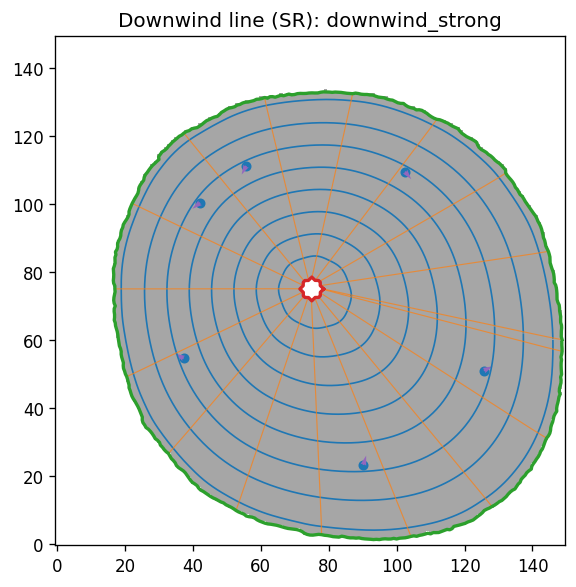

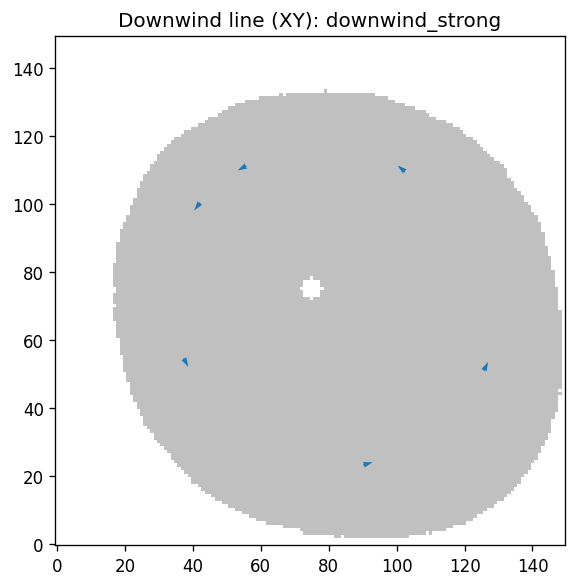

Applying retardant drop: D=[[ 37.275  54.556   2.638]
 [ 42.111 100.38    3.803]
 [ 55.676 111.241   4.23 ]
 [ 90.199  23.175   1.281]
 [102.463 109.553   5.401]
 [125.678  50.968   0.453]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


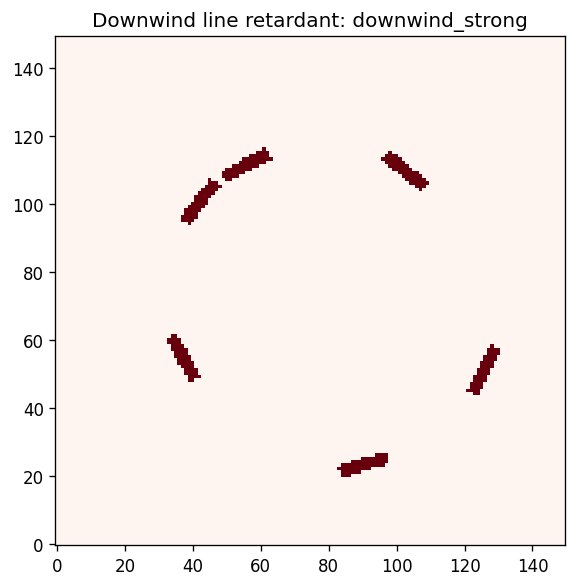

Config: downwind_soft
  sr_params: [[0.032 0.705 0.   ]
 [0.256 0.678 0.   ]
 [0.42  0.698 0.   ]
 [0.48  0.691 0.   ]
 [0.644 0.685 0.   ]
 [0.866 0.691 0.   ]]
  xy_params: [[ 34.481  79.664   3.257]
 [ 39.595  96.425   3.689]
 [ 49.989  36.633   2.141]
 [ 80.776 114.785   4.871]
 [110.999  29.887   0.9  ]
 [126.453  74.112   0.029]]


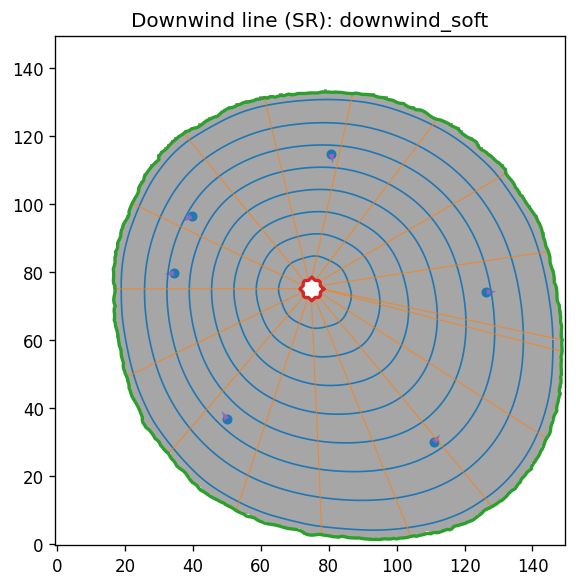

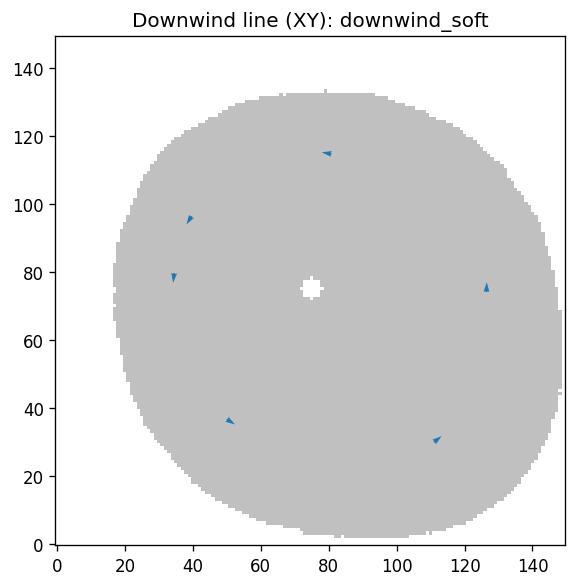

Applying retardant drop: D=[[ 34.481  79.664   3.257]
 [ 39.595  96.425   3.689]
 [ 49.989  36.633   2.141]
 [ 80.776 114.785   4.871]
 [110.999  29.887   0.9  ]
 [126.453  74.112   0.029]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


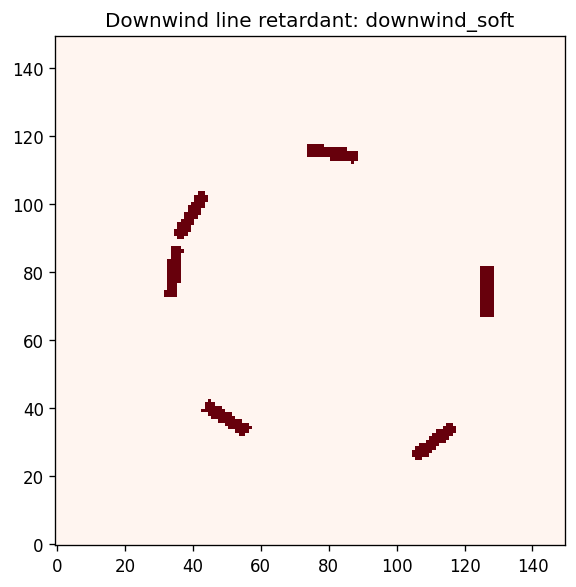

Config: near_downwind
  sr_params: [[0.07  0.597 0.   ]
 [0.118 0.617 0.   ]
 [0.166 0.584 0.   ]
 [0.592 0.57  0.   ]
 [0.64  0.597 0.   ]
 [0.69  0.617 0.   ]]
  xy_params: [[ 46.054  52.681   2.477]
 [ 52.186  41.926   2.166]
 [ 62.453  33.49    1.859]
 [101.166 102.505   5.492]
 [111.778  95.332   5.797]
 [116.561  83.869   6.088]]


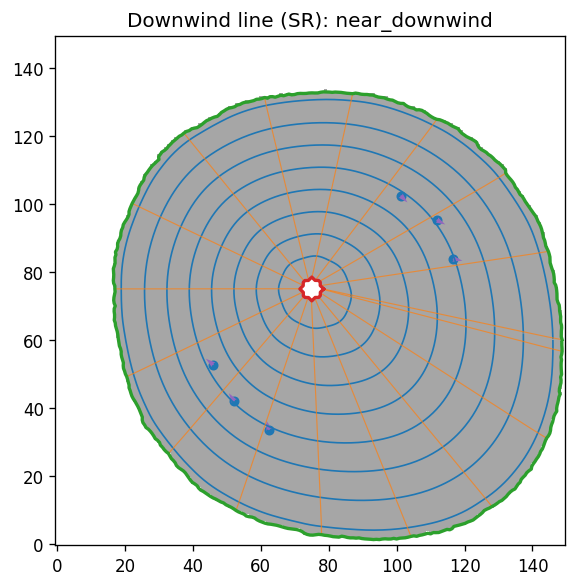

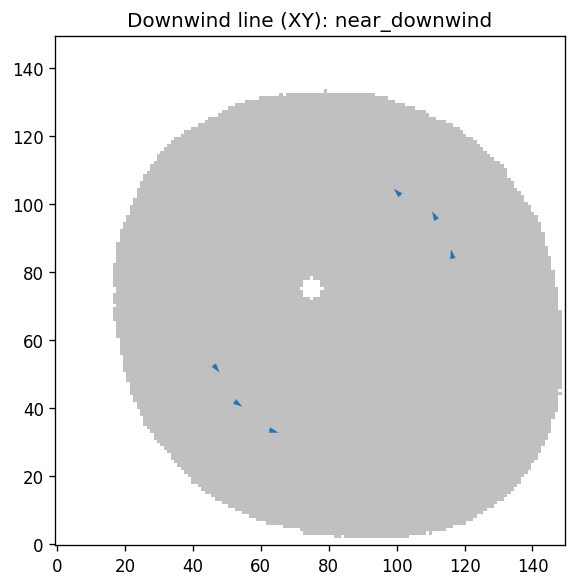

Applying retardant drop: D=[[ 46.054  52.681   2.477]
 [ 52.186  41.926   2.166]
 [ 62.453  33.49    1.859]
 [101.166 102.505   5.492]
 [111.778  95.332   5.797]
 [116.561  83.869   6.088]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


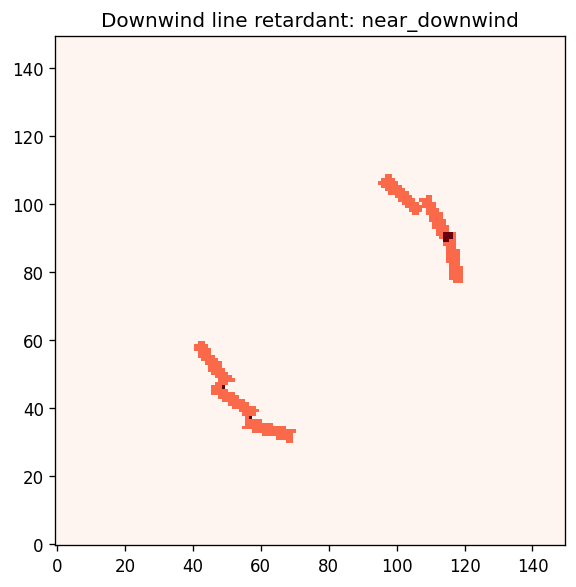

In [30]:
# Downwind line heuristic variations.

configs = [
    {"name": "downwind_strong", "r_value": 0.7, "wind_bias": 3.0, "line_spacing_scale": 0.9, "center_jitter_cells": 0.0, "jitter_r": 0.0},
    {"name": "downwind_soft", "r_value": 0.7, "wind_bias": 1.0, "line_spacing_scale": 0.9, "center_jitter_cells": 2.0, "jitter_r": 0.01},
    {"name": "near_downwind", "r_value": 0.6, "wind_bias": 2.0, "line_spacing_scale": 0.7, "center_jitter_cells": 3.0, "jitter_r": 0.02},
]

for cfg in configs:
    theta = bo.sample_downwind_line_theta(
        n=1,
        r_value=cfg["r_value"],
        wind_bias=cfg["wind_bias"],
        line_spacing_scale=cfg["line_spacing_scale"],
        center_jitter_cells=cfg["center_jitter_cells"],
        jitter_r=cfg["jitter_r"],
    )
    sr_params = bo.decode_theta_sr(theta)
    xy_params = bo.decode_theta(theta)

    print("" + f"Config: {cfg['name']}")
    print("  sr_params:", sr_params)
    print("  xy_params:", xy_params)

    plot_sr_points(bo, sr_params, f"Downwind line (SR): {cfg['name']}")
    plot_drop_overlay(bo.search_domain_mask, xy_params, f"Downwind line (XY): {cfg['name']}")
    render_retardant(model, xy_params, f"Downwind line retardant: {cfg['name']}")



Mixed heuristic #1
  sr_params: [[0.146 0.691 0.   ]
 [0.37  0.685 0.   ]
 [0.534 0.691 0.   ]
 [0.592 0.698 0.   ]
 [0.756 0.698 0.   ]
 [0.98  0.705 0.   ]]
  xy_params: [[ 35.068  64.477   2.877]
 [ 40.138  48.042   2.477]
 [ 49.557 106.768   4.044]
 [ 80.029  23.428   1.469]
 [110.334 103.523   5.621]
 [127.255  57.852   0.329]]


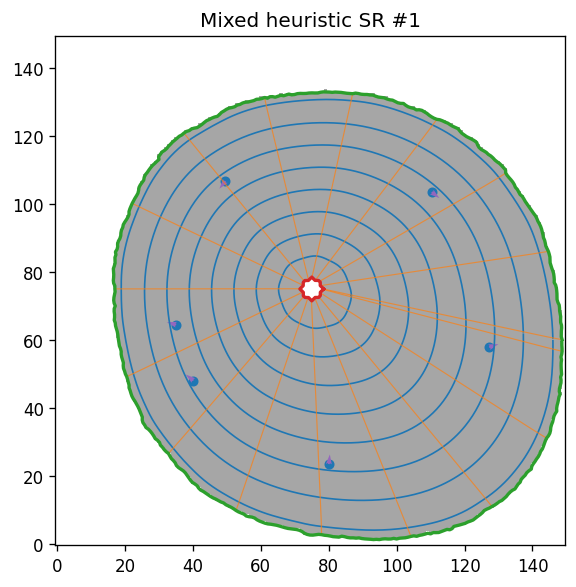

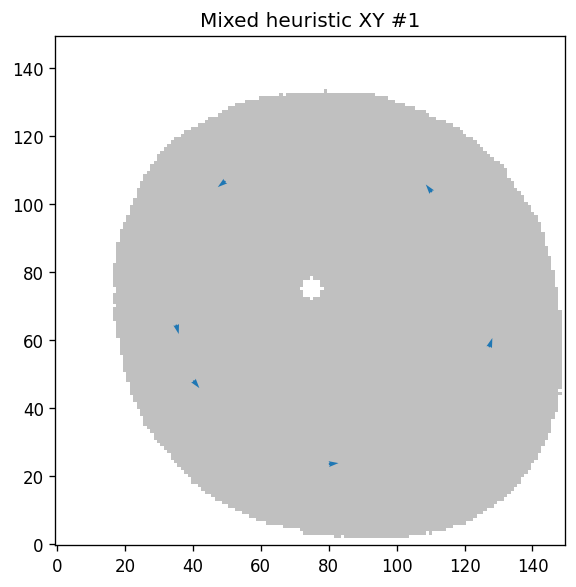


Mixed heuristic #2
  sr_params: [[0.002 0.691 0.   ]
 [0.166 0.698 0.   ]
 [0.224 0.691 0.   ]
 [0.39  0.685 0.   ]
 [0.612 0.685 0.   ]
 [0.776 0.698 0.   ]]
  xy_params: [[ 43.829  43.607   2.346]
 [ 45.256 102.998   3.902]
 [ 86.013  23.091   1.356]
 [ 90.226 114.073   5.103]
 [105.996 107.389   5.492]
 [126.475  65.274   0.199]]


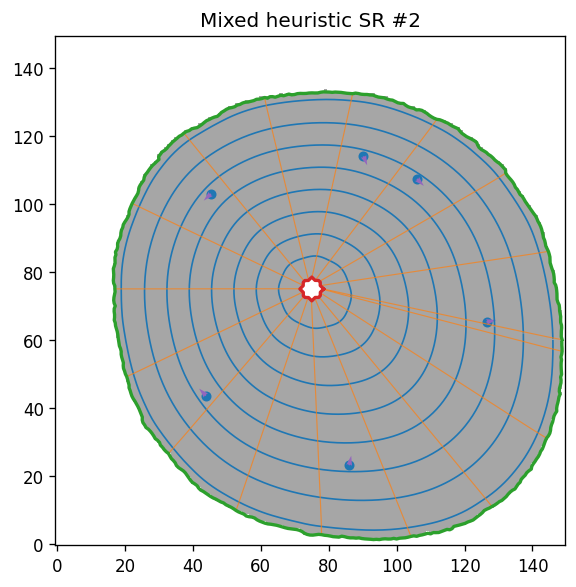

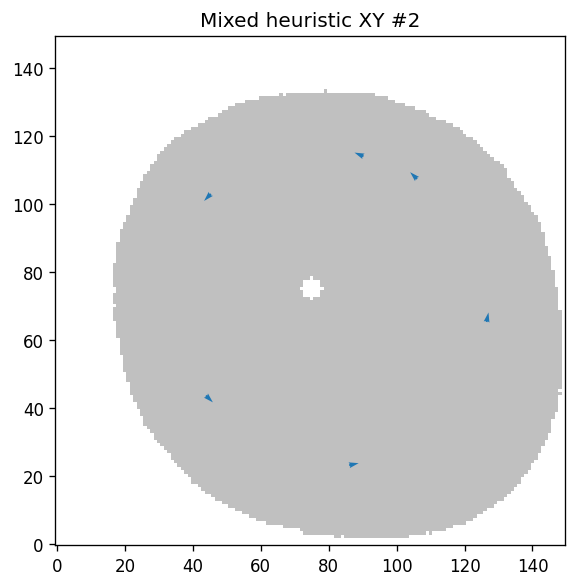


Mixed heuristic #3
  sr_params: [[0.785 0.806 0.091]
 [0.797 0.672 0.001]
 [0.829 0.672 0.041]
 [0.83  0.692 0.142]
 [0.835 0.678 0.031]
 [0.856 0.638 0.011]]
  xy_params: [[ 91.077  15.596   1.211]
 [ 91.929  25.227   1.238]
 [100.848  26.898   1.036]
 [101.584  25.531   0.935]
 [102.716  26.963   1.016]
 [106.058  31.825   0.938]]


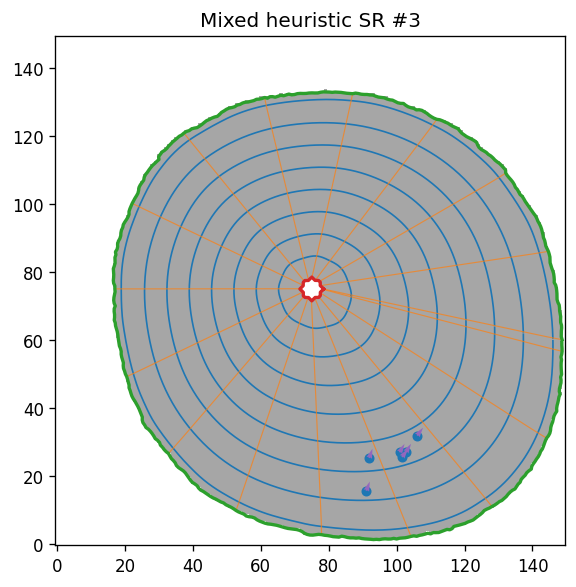

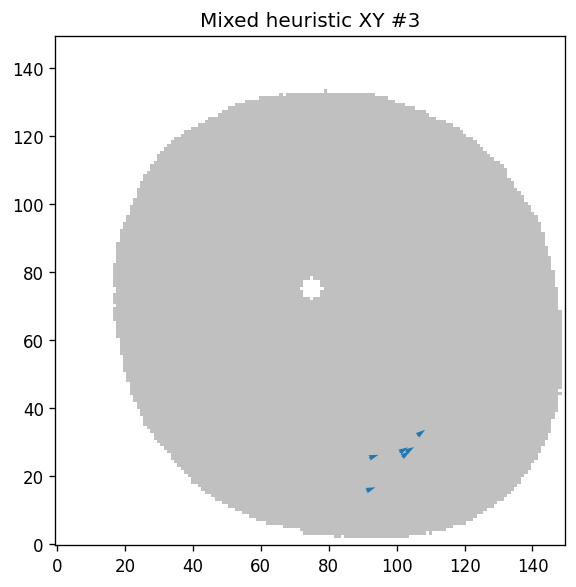

In [31]:
# Mixed heuristic sampling (value-blocking + uniform ring + downwind line).

heuristic_mix_kwargs = {
    "heuristic_value_prob": 0.5,
    "heuristic_uniform_ring_prob": 0.25,
    "heuristic_downwind_prob": 0.25,
    "heuristic_mix_prob": 0.2,
    "heuristic_mix_ratio": 0.5,
    "value_r_offset": -0.08,
    "value_jitter_s": 0.01,
    "value_jitter_delta_rad": float(np.deg2rad(6.0)),
    "uniform_ring_r_min": 0.6,
    "uniform_ring_r_max": 0.6,
    "uniform_ring_phase": None,
    "uniform_ring_jitter_s": 0.02,
    "uniform_ring_jitter_r": 0.01,
    "downwind_line_r_value": 0.7,
    "downwind_line_wind_bias": 2.0,
    "downwind_line_spacing_scale": 0.9,
    "downwind_line_center_jitter_cells": 2.0,
    "downwind_line_jitter_r": 0.01,
}

init_mix_kwargs = {
    "init_heuristic_value_prob": heuristic_mix_kwargs["heuristic_value_prob"],
    "init_heuristic_uniform_ring_prob": heuristic_mix_kwargs["heuristic_uniform_ring_prob"],
    "init_heuristic_downwind_prob": heuristic_mix_kwargs["heuristic_downwind_prob"],
    "init_heuristic_mix_prob": heuristic_mix_kwargs["heuristic_mix_prob"],
    "init_heuristic_mix_ratio": heuristic_mix_kwargs["heuristic_mix_ratio"],
    "init_value_r_offset": heuristic_mix_kwargs["value_r_offset"],
    "init_value_jitter_s": heuristic_mix_kwargs["value_jitter_s"],
    "init_value_jitter_delta_rad": heuristic_mix_kwargs["value_jitter_delta_rad"],
    "init_uniform_ring_r_min": heuristic_mix_kwargs["uniform_ring_r_min"],
    "init_uniform_ring_r_max": heuristic_mix_kwargs["uniform_ring_r_max"],
    "init_uniform_ring_phase": heuristic_mix_kwargs["uniform_ring_phase"],
    "init_uniform_ring_jitter_s": heuristic_mix_kwargs["uniform_ring_jitter_s"],
    "init_uniform_ring_jitter_r": heuristic_mix_kwargs["uniform_ring_jitter_r"],
    "init_downwind_line_r_value": heuristic_mix_kwargs["downwind_line_r_value"],
    "init_downwind_line_wind_bias": heuristic_mix_kwargs["downwind_line_wind_bias"],
    "init_downwind_line_spacing_scale": heuristic_mix_kwargs["downwind_line_spacing_scale"],
    "init_downwind_line_center_jitter_cells": heuristic_mix_kwargs["downwind_line_center_jitter_cells"],
    "init_downwind_line_jitter_r": heuristic_mix_kwargs["downwind_line_jitter_r"],
}

mix_thetas = bo.sample_initial_thetas(
    n_init=3,
    strategy="heuristic",
    heuristic_random_frac=0.0,
    heuristic_kwargs={"value_offset": value_background, "value_power": 2.0},
    **heuristic_mix_kwargs,
)

for k, theta in enumerate(np.atleast_2d(mix_thetas), start=1):
    sr_params = bo.decode_theta_sr(theta)
    xy_params = bo.decode_theta(theta)
    print("\n" + f"Mixed heuristic #{k}")
    print("  sr_params:", sr_params)
    print("  xy_params:", xy_params)
    plot_sr_points(bo, sr_params, f"Mixed heuristic SR #{k}")
    plot_drop_overlay(bo.search_domain_mask, xy_params, f"Mixed heuristic XY #{k}")


In [32]:
# Heuristic-only optimization (mixed heuristics).

heuristic_kwargs = {
    "value_power": 2.0,
    "value_offset": value_background,
    "r_offset": -0.08,
    "jitter_s": 0.01,
    "jitter_delta_rad": float(np.deg2rad(6.0)),
}

best_theta, best_params, best_y, (X_feats, y_vals), y_nexts, y_bests = bo.run_heuristic_search(
    n_evals=25,
    K_grid=300,
    boundary_field="affected",
    n_r=120,
    smooth_iters=300,
    omega=1.0,
    heuristic_random_frac=0.2,
    heuristic_kwargs=heuristic_kwargs,
    **heuristic_mix_kwargs,
    verbose=True,
    print_every=5,
    plot_each=True,
    plot_each_n_sims=1
)

plt.figure(figsize=(6, 4))
plt.plot(y_bests, marker="o")
plt.xlabel("iteration")
plt.ylabel("best_y")
plt.title("Heuristic (SR) best objective")
plt.tight_layout()
plt.show()

plot_drop_overlay(bo.search_domain_mask, best_params, "Heuristic best (x,y,phi)")
render_retardant(model, best_params, "Heuristic best retardant overlay")
_ = bo.plot_evolved_firestate(best_theta, n_sims=10, title_prefix="Heuristic best")


Applying retardant drop: D=[[ 41.101  88.217   3.517]
 [ 86.934  30.649   1.206]
 [ 91.678  30.566   1.116]
 [101.817  19.866   1.146]
 [105.64   19.342   1.182]
 [109.95   39.264   0.801]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


KeyboardInterrupt: 

In [ ]:
# BO in SR space (SR-native features and kernel).

best_theta, best_params, best_y, (X_feats, y_vals), y_nexts, y_bests = bo.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12,
    xi=0.03,
    K_grid=300,
    boundary_field="affected",
    n_r=120,
    smooth_iters=300,
    omega=1.0,
    verbose=True,
    print_every=10,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.25,
    init_heuristic_kwargs=heuristic_kwargs,
    **init_mix_kwargs,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_global_masked=True,
    candidate_local_frac=0.7,
    candidate_local_top_k=5,
    candidate_local_sigma_s=0.025,
    candidate_local_sigma_r=0.025,
    candidate_local_sigma_delta_rad=np.deg2rad(10.0),
    candidate_local_resample_delta_prob=0.25,
    use_ard_kernel=False
)

plt.figure(figsize=(6, 4))
plt.plot(y_bests, marker="o")
plt.xlabel("iteration")
plt.ylabel("best_y")
plt.title("BO (SR) best objective")
plt.tight_layout()
plt.show()

plot_drop_overlay(bo.search_domain_mask, best_params, "BO best (x,y,phi)")
render_retardant(model, best_params, "BO best retardant overlay")
_ = bo.plot_evolved_firestate(best_theta, n_sims=10, title_prefix="BO best")


Applying retardant drop: D=[[ 38.51   88.637   4.802]
 [ 44.073 108.53    0.88 ]
 [ 52.546 109.593   1.67 ]
 [ 64.479  77.057   2.953]
 [ 81.829  98.028   2.31 ]
 [ 98.557  79.128   2.974]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Applying retardant drop: D=[[ 34.967  65.061   2.891]
 [ 45.617  96.999   3.789]
 [ 71.115  31.387   1.655]
 [117.87   49.648   0.543]
 [120.849  89.46    5.992]
 [124.473  39.168   0.633]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Applying retardant drop: D=[[ 89.361  14.152   1.368]
 [ 91.321  19.413   1.191]
 [ 96.488  24.355   1.211]
 [ 97.018  28.501   1.006]
 [100.136  29.332   0.94 ]
 [105.056  22.906   1.073]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


KeyboardInterrupt: 